In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

## Exploratory Data Analysis

In [2]:
df = pd.read_csv("clean_data.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,sunroof,alloywheels,aircondition,nav,bluetooth,pushstart,parkingassist,cruisecontrol,trailerhitch,url,...,make,model,colour,body,doors,seating,transmission,fuel,km,description
0,1,1,1,0,0,0,0,1,0,https://www.kijiji.ca/v-cars-trucks/city-of-to...,...,Toyota,4Runner,Grey,"SUV, Crossover",4,5,Automatic,Gasoline,384900.0,3rd Gen Toyota 4RunnerRunning strong at 385k. ...
1,1,1,1,0,0,0,0,1,0,https://www.kijiji.ca/v-cars-trucks/city-of-to...,...,Subaru,Outback,Blue,Wagon,5,5,Automatic,Gasoline,239000.0,"Subaru Outback 2005 2.5, 170 hp. With 239000 k..."
2,0,0,1,0,1,1,0,0,0,https://www.kijiji.ca/v-cars-trucks/city-of-to...,...,Mazda,Other,Silver,Sedan,4,5,Automatic,Gasoline,66000.0,"10,900 or best offer\r\nMazda3 CX in amazing c..."
3,0,0,0,0,0,0,0,0,0,https://www.kijiji.ca/v-cars-trucks/city-of-to...,...,Suzuki,Swift,Black,Sedan,4,5,Manual,Gasoline,214300.0,"2007 Suzuki swift, good condition, unfortunate..."
4,0,0,1,0,1,0,0,1,0,https://www.kijiji.ca/v-cars-trucks/city-of-to...,...,Honda,Civic,Silver,Sedan,4,4,Automatic,Gasoline,227850.0,2003 Honda Civic in very good condition does n...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2734 entries, 0 to 2733
Data columns (total 24 columns):
sunroof          2734 non-null int64
alloywheels      2734 non-null int64
aircondition     2734 non-null int64
nav              2734 non-null int64
bluetooth        2734 non-null int64
pushstart        2734 non-null int64
parkingassist    2734 non-null int64
cruisecontrol    2734 non-null int64
trailerhitch     2734 non-null int64
url              2734 non-null object
title            2734 non-null object
price            2734 non-null float64
condition        2734 non-null object
year             2734 non-null float64
make             2734 non-null object
model            2734 non-null object
colour           2734 non-null object
body             2734 non-null object
doors            2734 non-null int64
seating          2734 non-null int64
transmission     2734 non-null object
fuel             2734 non-null object
km               2734 non-null float64
description      2734 non-n

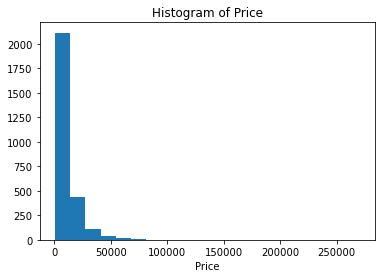

In [4]:
# Price is heavily leaning towards the first bin, maybe log will map it nicely
plt.hist(df.price, bins=20);
plt.xlabel('Price');
plt.title("Histogram of Price");

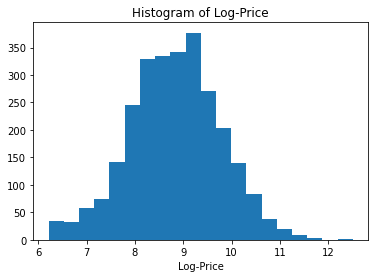

In [5]:
plt.hist(np.log(df.price), bins=20);
plt.xlabel('Log-Price');
plt.title("Histogram of Log-Price");

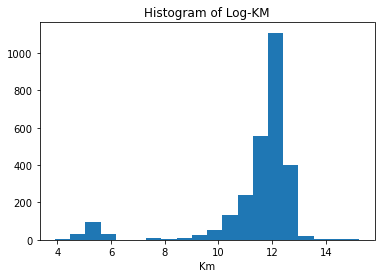

In [6]:
plt.hist(np.log(df.km), bins=20);
plt.xlabel('Km');
plt.title("Histogram of Log-KM");

After doing a logarithmic transformation on the price, the histogram suggests a normal distribution which is good for regression. Even after a logarithmic transformation of KM, the data is skewed left and might need more transformations to make it normal in order to improve the performance of regression models.

In [7]:
def classify_price(x):    
    if x<4000:
        return "<$4000"
    
    if x >= 4000 and x <= 10000:
        return "$4000-$10000"
    
    if x>10000:
        return ">$10000"
    return "NA"

In [8]:
df['classifications'] = df.price.apply(classify_price)

In [9]:
# Effect of make to price
piv = pd.pivot_table(df,index=['make'],columns='classifications',values=[],aggfunc=len)
piv.fillna(0, inplace=True)
piv = piv[['<$4000','$4000-$10000','>$10000']]
piv = piv.div(piv.sum(axis=1), axis = 0) * 100

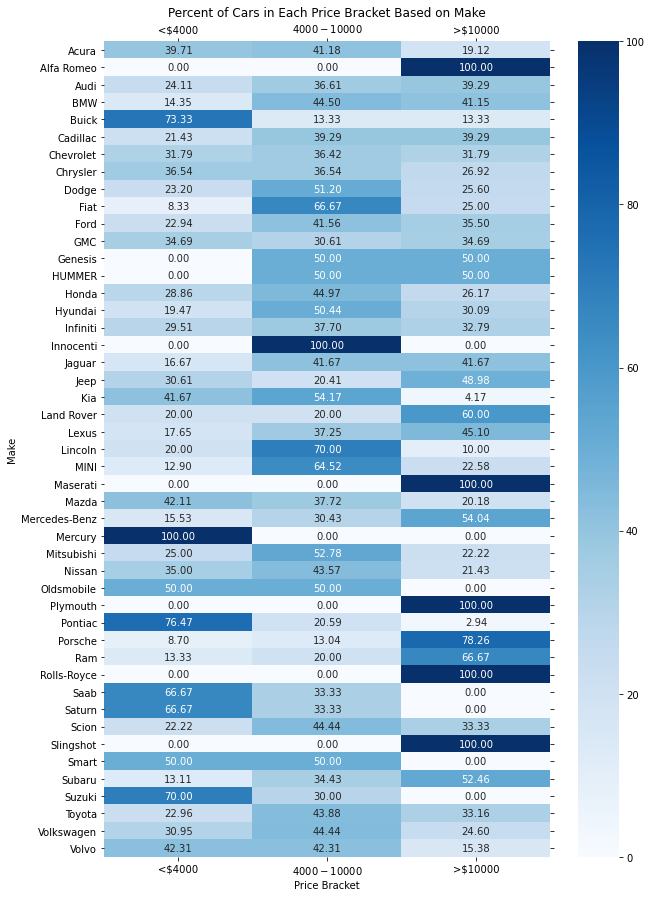

In [10]:
plt.subplots(figsize=(10,15))
sns.heatmap(piv,cmap="Blues",annot=True,fmt=".2f");
plt.xlabel("Price Bracket")
plt.ylabel("Make");
plt.title("Percent of Cars in Each Price Bracket Based on Make");
plt.tick_params(right=True, top=True, labeltop=True,rotation=0);

Premium luxury European imports such as BMW, Porsche, Audi and Mercedes-Benz have most of their cars listed at \\$10000 or higher. Brands such as Toyota, Honda, Kia, Nissan and Chevrolet have their cars mostly listed under \\$10000. The less than \\$4000 cars tend to affect discontinued makes such as Oldsmobile and Saturn which explains the low pricing. Other makes such as suzuki and pontiac could be due to the lower perception of brand quality in the used market.

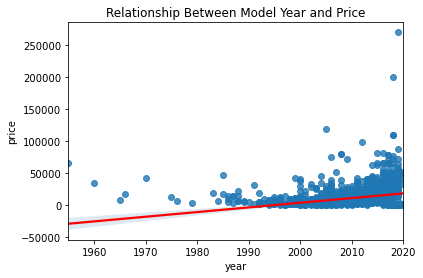

In [11]:
g = sns.regplot(x="year",y="price",data=df);
regline = g.get_lines()[0]
regline.set_color('red')
plt.title("Relationship Between Model Year and Price");

As expected, a newer car in general will command a higher price

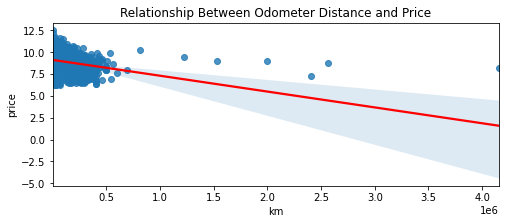

In [12]:
plt.subplots(figsize=(8,3))
g = sns.regplot(x="km",y=np.log(df.price),data=df);
regline = g.get_lines()[0]
regline.set_color('red')
plt.title("Relationship Between Odometer Distance and Price");

More kilometers driven means the car's value generally is lower.

In [13]:
def draw_boxplots(df, cols,target,func):
    for col in cols:
        sns.boxplot(x=df[col], y=func(df[target]));
        plt.title("Boxplot of {}".format(col));
        plt.ylabel("Log-Price")
        plt.show();

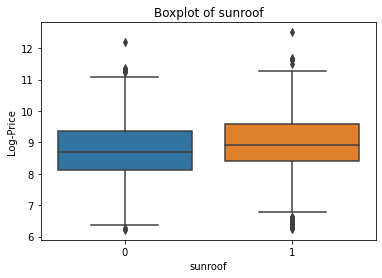

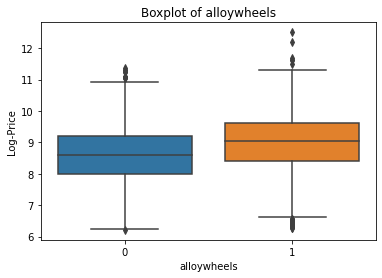

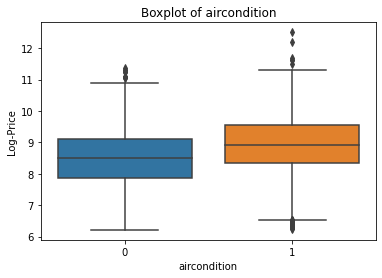

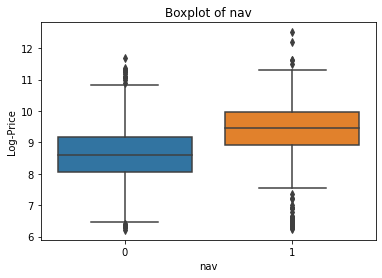

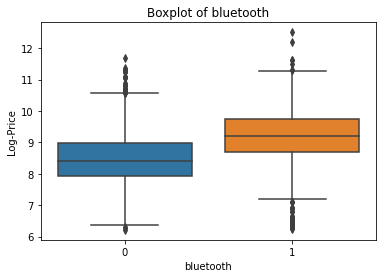

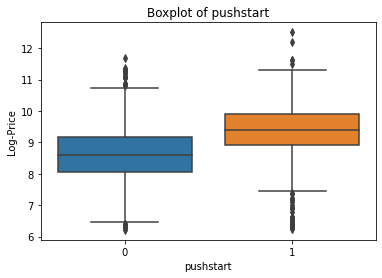

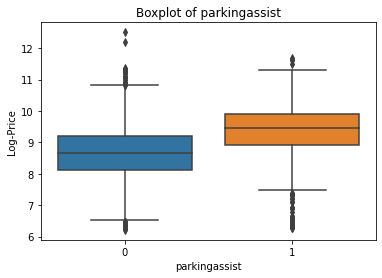

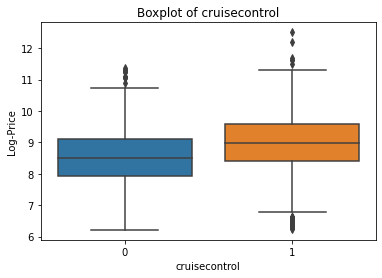

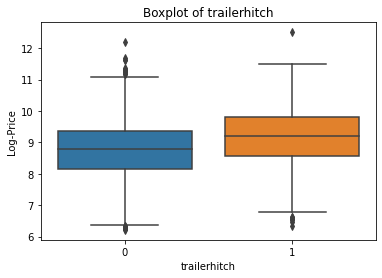

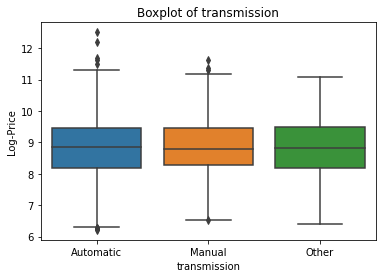

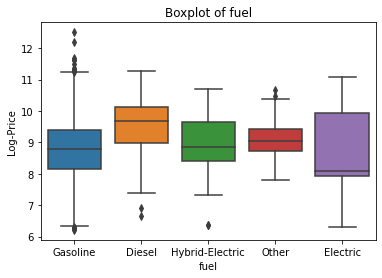

In [14]:
columns = np.append(df.columns[0:9],df.columns[20:22]) 
draw_boxplots(df,columns,"price",np.log)

From the box plots, additional features such as a navigation dashboard, alloy wheels, etc on average increase the price of the used car.There doesn't seem to be much of a difference in pricing between different transmissions but the variance in automatic car pricing is much higher, which can be due to the fact that there are more automatic cars for sale. Electric cars have a high variance, maybe it could be due to the resale value electric cars depends on the make more than the fuel. Diesel cars tended to be much more expensive than gasoline and electric cars. This can be explained because diesel engines cost more to build and in turn sell at a higher price at the showroom. 

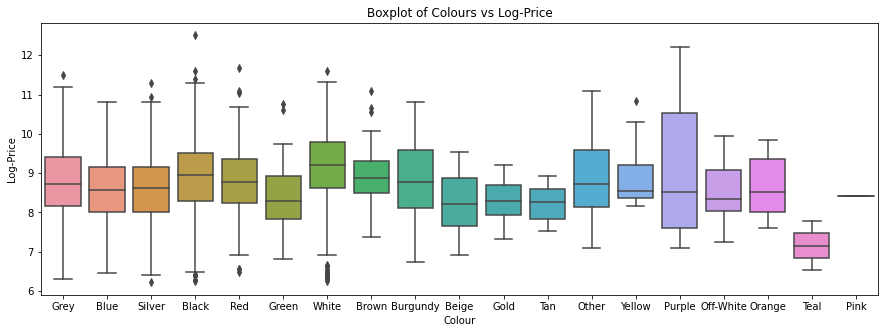

In [15]:
plt.subplots(figsize=(15,5))
sns.boxplot(x=df.colour, y=np.log(df.price));
plt.ylabel("Log-Price");
plt.xlabel("Colour");
plt.title("Boxplot of Colours vs Log-Price");

The colour white seems to command the highest cost of a vehicle. Teal being the lowest. Purple seems to vary the price, due to the limited amount of vehicles painted purple.

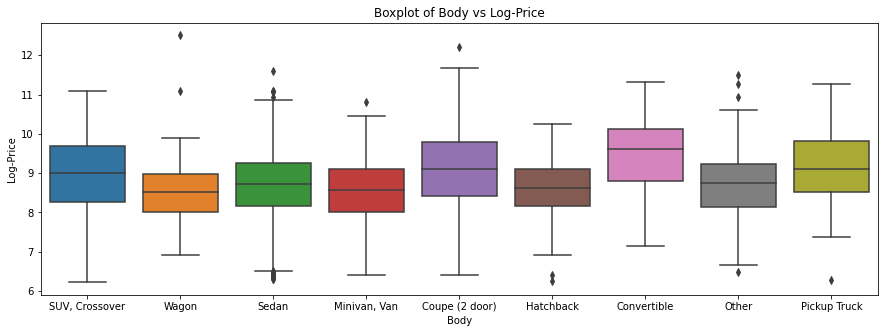

In [16]:
plt.subplots(figsize=(15,5))
sns.boxplot(x=df.body, y=np.log(df.price));
plt.ylabel("Log-Price");
plt.xlabel("Body");
plt.title("Boxplot of Body vs Log-Price");

Convertibles and coupes are the most expensive. Pickup trucks are just as expensive as coupe's on average, could be due to them being more expensive when adding additional and specific add-ons. 

#### EDA Conclusions
<li>Make of car affects price especially for luxury import cars such as BMW, Alfa Romeo, Mercedes and Porsche where these makes have a higher price.</li>
<li>Features such as navigation dashboards and pushstart on average commands a higher price</li>
<li>Diesel engines make cars more expensive while electric cars sell for less</li>
<li>Transmission doesn't really affect the car values</li>
<li>Colours can vary the price by alot but on average white and black were on average the most expensive</li>
<li>Body type has an affect on price where having a convertible can increase the price considerably</li>

## Feature Engineering

In [17]:
df.head()

,sunroof,alloywheels,aircondition,nav,bluetooth,pushstart,parkingassist,cruisecontrol,trailerhitch,url,...,model,colour,body,doors,seating,transmission,fuel,km,description,classifications
0,1,1,1,0,0,0,0,1,0,https://www.kijiji.ca/v-cars-trucks/city-of-to...,...,4Runner,Grey,"SUV, Crossover",4,5,Automatic,Gasoline,384900.0,3rd Gen Toyota 4RunnerRunning strong at 385k. ...,<$4000
1,1,1,1,0,0,0,0,1,0,https://www.kijiji.ca/v-cars-trucks/city-of-to...,...,Outback,Blue,Wagon,5,5,Automatic,Gasoline,239000.0,"Subaru Outback 2005 2.5, 170 hp. With 239000 k...",<$4000
2,0,0,1,0,1,1,0,0,0,https://www.kijiji.ca/v-cars-trucks/city-of-to...,...,Other,Silver,Sedan,4,5,Automatic,Gasoline,66000.0,"10,900 or best offer\r\nMazda3 CX in amazing c...",>$10000
3,0,0,0,0,0,0,0,0,0,https://www.kijiji.ca/v-cars-trucks/city-of-to...,...,Swift,Black,Sedan,4,5,Manual,Gasoline,214300.0,"2007 Suzuki swift, good condition, unfortunate...",<$4000
4,0,0,1,0,1,0,0,1,0,https://www.kijiji.ca/v-cars-trucks/city-of-to...,...,Civic,Silver,Sedan,4,4,Automatic,Gasoline,227850.0,2003 Honda Civic in very good condition does n...,<$4000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2734 entries, 0 to 2733
Data columns (total 25 columns):
sunroof            2734 non-null int64
alloywheels        2734 non-null int64
aircondition       2734 non-null int64
nav                2734 non-null int64
bluetooth          2734 non-null int64
pushstart          2734 non-null int64
parkingassist      2734 non-null int64
cruisecontrol      2734 non-null int64
trailerhitch       2734 non-null int64
url                2734 non-null object
title              2734 non-null object
price              2734 non-null float64
condition          2734 non-null object
year               2734 non-null float64
make               2734 non-null object
model              2734 non-null object
colour             2734 non-null object
body               2734 non-null object
doors              2734 non-null int64
seating            2734 non-null int64
transmission       2734 non-null object
fuel               2734 non-null object
km                 273

In [19]:
df = df.drop(columns=['url'])
df.head()

,sunroof,alloywheels,aircondition,nav,bluetooth,pushstart,parkingassist,cruisecontrol,trailerhitch,title,...,model,colour,body,doors,seating,transmission,fuel,km,description,classifications
0,1,1,1,0,0,0,0,1,0,1999 Toyota 4Runner Limited,...,4Runner,Grey,"SUV, Crossover",4,5,Automatic,Gasoline,384900.0,3rd Gen Toyota 4RunnerRunning strong at 385k. ...,<$4000
1,1,1,1,0,0,0,0,1,0,"2005 Subaru Outback, very good condition, no rust",...,Outback,Blue,Wagon,5,5,Automatic,Gasoline,239000.0,"Subaru Outback 2005 2.5, 170 hp. With 239000 k...",<$4000
2,0,0,1,0,1,1,0,0,0,"2014 Mazda CX 66,000 KM ONLY",...,Other,Silver,Sedan,4,5,Automatic,Gasoline,66000.0,"10,900 or best offer\r\nMazda3 CX in amazing c...",>$10000
3,0,0,0,0,0,0,0,0,0,2007 Suzuki Swift,...,Swift,Black,Sedan,4,5,Manual,Gasoline,214300.0,"2007 Suzuki swift, good condition, unfortunate...",<$4000
4,0,0,1,0,1,0,0,1,0,Price include safety,...,Civic,Silver,Sedan,4,4,Automatic,Gasoline,227850.0,2003 Honda Civic in very good condition does n...,<$4000


In [20]:
# Let's see if the word needs has any effect  on the price
df['needs'] = df.description.apply(lambda x: x.lower().count("needs") or x.lower().count("need"))

In [21]:
df.needs.value_counts()

0    2241
1     441
2      46
3       5
4       1
Name: needs, dtype: int64

In [22]:
# See if repair or repairs has any effect
df['repairs'] = df.description.apply(lambda x: x.lower().count("repairs") or x.lower().count("repair"))

In [23]:
df.repairs.value_counts()

0    2669
1      58
2       6
3       1
Name: repairs, dtype: int64

In [24]:
df['issues'] = df.description.apply(lambda x: x.lower().count("issues")or x.lower().count("issue"))

In [25]:
df.issues.value_counts()

0    2499
1     220
2      14
3       1
Name: issues, dtype: int64

In [26]:
df['dents']=df.description.apply(lambda x: x.lower().count("dent")or x.lower().count("dents"))

In [27]:
df.dents.value_counts()

0    2216
1     474
2      42
3       1
4       1
Name: dents, dtype: int64

In [28]:
df['scratches']=df.description.apply(lambda x: x.lower().count("scratch")or x.lower().count("scratches"))

In [29]:
df.scratches.value_counts()

0    2651
1      81
2       2
Name: scratches, dtype: int64

In [30]:
df['description_len']=df.description.apply(lambda x: len(x.strip()))

In [31]:
df.description_len.value_counts()

83      18
219     16
107     15
77      13
97      13
        ..
1278     1
1280     1
1296     1
1302     1
6        1
Name: description_len, Length: 860, dtype: int64

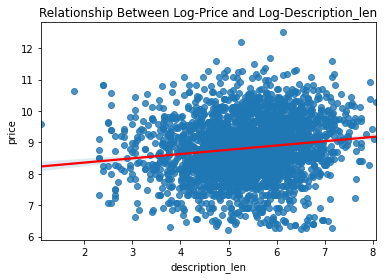

In [32]:
g = sns.regplot(x=np.log(df.description_len),y=np.log(df.price))
regline = g.get_lines()[0]
regline.set_color('red')
plt.title("Relationship Between Log-Price and Log-Description_len");
plt.show();

In [33]:
def display_regplots(df,columns,target,func):
    for col in columns:
        g = sns.regplot(x=col,y=func(df[target]),data=df);
        regline = g.get_lines()[0]
        regline.set_color('red')
        plt.title("Relationship Between {} and {}".format(col,target));
        plt.show();

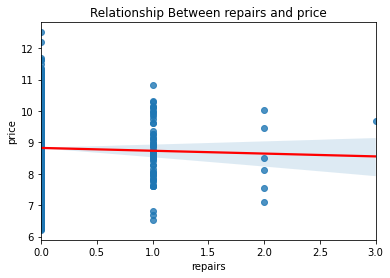

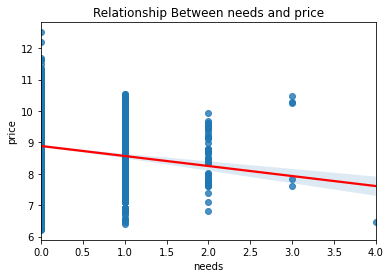

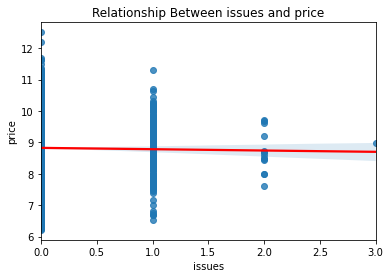

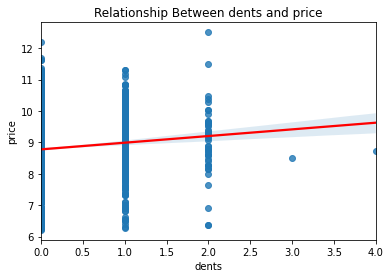

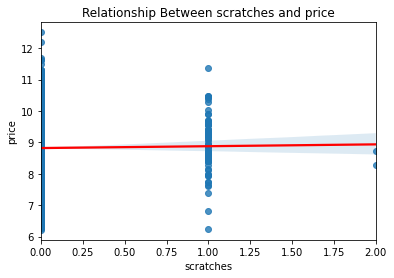

In [34]:
cols = ['repairs','needs','issues','dents','scratches']
display_regplots(df,cols,'price',np.log)

In [35]:
df['log_price'] = np.log(df.price)

In [36]:
df = df.drop(columns=['description','classifications','title'])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2734 entries, 0 to 2733
Data columns (total 28 columns):
sunroof            2734 non-null int64
alloywheels        2734 non-null int64
aircondition       2734 non-null int64
nav                2734 non-null int64
bluetooth          2734 non-null int64
pushstart          2734 non-null int64
parkingassist      2734 non-null int64
cruisecontrol      2734 non-null int64
trailerhitch       2734 non-null int64
price              2734 non-null float64
condition          2734 non-null object
year               2734 non-null float64
make               2734 non-null object
model              2734 non-null object
colour             2734 non-null object
body               2734 non-null object
doors              2734 non-null int64
seating            2734 non-null int64
transmission       2734 non-null object
fuel               2734 non-null object
km                 2734 non-null float64
needs              2734 non-null int64
repairs            273

In [38]:
# Create dummies for categorical variables
make_dummies = pd.get_dummies(df.make,prefix="make", drop_first=True)
model_dummies = pd.get_dummies(df.model,prefix="model", drop_first=True)
colour_dummies = pd.get_dummies(df.colour,prefix="colour", drop_first=True)
body_dummies = pd.get_dummies(df.body,prefix="body", drop_first=True)
transmission_dummies = pd.get_dummies(df.transmission,prefix="transmission", drop_first=True)
fuel_dummies = pd.get_dummies(df.fuel,prefix="fuel", drop_first=True)
df = pd.concat([df,make_dummies,model_dummies,colour_dummies, body_dummies, transmission_dummies, fuel_dummies], axis=1)

In [39]:
# Drop the unused variables
df = df.drop(columns=['condition','make','model','colour','body','transmission','fuel'])

In [40]:
df

,sunroof,alloywheels,aircondition,nav,bluetooth,pushstart,parkingassist,cruisecontrol,trailerhitch,price,...,body_Pickup Truck,"body_SUV, Crossover",body_Sedan,body_Wagon,transmission_Manual,transmission_Other,fuel_Electric,fuel_Gasoline,fuel_Hybrid-Electric,fuel_Other
0,1,1,1,0,0,0,0,1,0,3850.0,...,0,1,0,0,0,0,0,1,0,0
1,1,1,1,0,0,0,0,1,0,3850.0,...,0,0,0,1,0,0,0,1,0,0
2,0,0,1,0,1,1,0,0,0,10900.0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1100.0,...,0,0,1,0,1,0,0,1,0,0
4,0,0,1,0,1,0,0,1,0,2600.0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729,1,0,1,0,0,0,0,1,0,4700.0,...,0,0,1,0,0,0,0,1,0,0
2730,0,1,0,0,0,0,0,1,0,3700.0,...,0,1,0,0,0,0,0,1,0,0
2731,0,1,1,0,0,0,0,1,1,10000.0,...,1,0,0,0,1,0,0,0,0,0
2732,0,0,0,0,0,0,0,0,0,3700.0,...,0,1,0,0,0,0,0,1,0,0


In [41]:
X = df.loc[:,df.columns != "log_price"]
y = df.log_price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Use f-test pval < 0.05 to select the important features to be evaluated with recursive feature elimination
p_vals = f_regression(X_train,y_train)[1]
criteria = p_vals < 0.05
X_train = X_train.loc[:,criteria]
X_train.columns

Index(['sunroof', 'alloywheels', 'aircondition', 'nav', 'bluetooth',
       'pushstart', 'parkingassist', 'cruisecontrol', 'trailerhitch', 'price',
       ...
       'colour_Silver', 'colour_Teal', 'colour_White', 'body_Coupe (2 door)',
       'body_Hatchback', 'body_Minivan, Van', 'body_Pickup Truck',
       'body_SUV, Crossover', 'body_Sedan', 'fuel_Gasoline'],
      dtype='object', length=128)

In [43]:
# Update the features of the test set
X_test = X_test[X_train.columns]

In [44]:
numeric_features = X_train.select_dtypes(include=['float64','int64']).iloc[:,10:] 
numeric_features['year'] = X_train.year

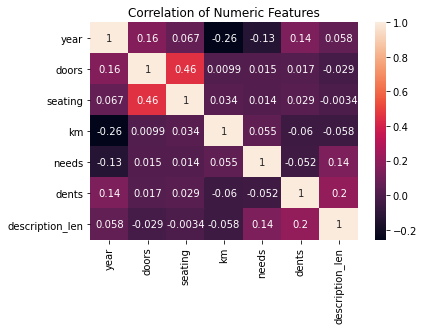

In [45]:
sns.heatmap(numeric_features.corr(),annot=True);
plt.title("Correlation of Numeric Features");

It doesn't look like any of the numeric features are correlated so for regression we can't remove variables.